<a href="https://colab.research.google.com/github/luancordeiro/lidarpy/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/luancordeiro/lidarpy.git

Cloning into 'lidarpy'...
remote: Enumerating objects: 287, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 287 (delta 41), reused 61 (delta 26), pack-reused 205
Receiving objects: 100% (287/287), 67.04 MiB | 11.51 MiB/s, done.
Resolving deltas: 100% (185/185), done.


In [4]:
import os
os.chdir("lidarpy")

In [5]:
from lidarpy import GetData

directory = "/content/lidarpy/lidarpy/tests/data/binary"
files = [file for file in os.listdir(directory) if file.startswith("RM")]
files.sort()

data = GetData(directory, files)
lidar_data = data.get_xarray()
lidar_data

<xarray.DataArray (time: 119, wavelength: 5, altitude: 16380)>
array([[[  1.98522949,   1.98376465,   1.98392741, ...,   1.98954264,
           1.98669434,   1.98819987],
        [113.93333333, 104.9       , 100.43333333, ...,   0.        ,
           0.        ,   0.        ],
        [  2.02790527,   2.02873535,   2.02804362, ...,   2.03680013,
           2.0347168 ,   2.03548991],
        [ 61.33333333,  50.        ,  40.2       , ...,   0.        ,
           0.        ,   0.        ],
        [  2.3       ,   1.4       ,   1.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  1.98494466,   1.98417155,   1.98494466, ...,   1.98868815,
           1.98775228,   1.98954264],
        [114.5       , 103.03333333, 101.16666667, ...,   0.        ,
           0.        ,   0.        ],
        [  2.02931315,   2.02963053,   2.02929688, ...,   2.03629557,
           2.03545736,   2.03633626],
        [ 59.2       ,  50.63333333,  39.36666667, ...,   0.        ,
           0.        ,   0.        ],
        [  2.13333333,   1.4       ,   0.93333333, ...,   0.        ,
...
           1.98673503,   1.98636882],
        [116.96666667, 108.        , 101.6       , ...,   0.        ,
           0.        ,   0.        ],
        [  2.02666829,   2.02672526,   2.02703451, ...,   2.03343913,
           2.03416341,   2.03550618],
        [ 62.13333333,  49.3       ,  39.33333333, ...,   0.        ,
           0.        ,   0.        ],
        [  2.3       ,   1.86666667,   0.9       , ...,   0.        ,
           0.        ,   0.        ]],

       [[  1.98010254,   1.98262533,   1.9802653 , ...,   1.98616536,
           1.9868571 ,   1.98506673],
        [117.4       , 108.33333333, 104.23333333, ...,   0.        ,
           0.        ,   0.        ],
        [  2.02862142,   2.02786458,   2.02790527, ...,   2.03475749,
           2.03473307,   2.0342041 ],
        [ 63.16666667,  49.2       ,  40.4       , ...,   0.        ,
           0.        ,   0.        ],
        [  2.56666667,   1.33333333,   0.8       , ...,   0.        ,
           0.        ,   0.        ]]])
Coordinates:
  * time        (time) float64 7.35e+05 7.35e+05 7.35e+05 ... 7.35e+05 7.35e+05
  * wavelength  (wavelength) <U5 '355_0' '355_1' '387_0' '387_1' '408_1'
  * altitude    (altitude) float64 7.5 15.0 22.5 ... 1.228e+05 1.228e+05

# Removing background noise

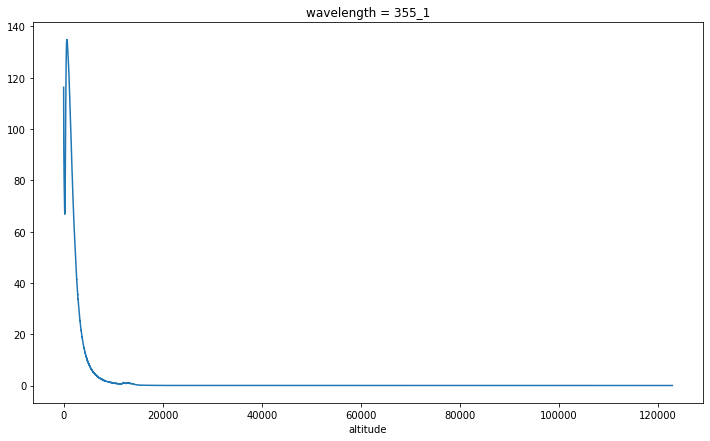

In [6]:
(lidar_data
 .mean("time")
 .sel(wavelength="355_1")
 .plot(figsize=(12, 7)))

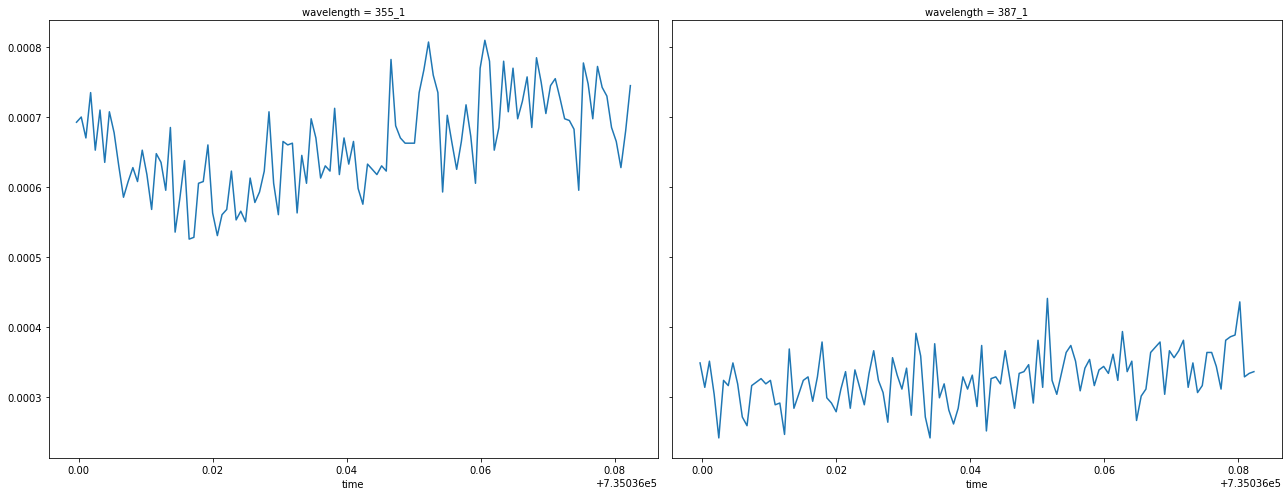

In [7]:
lidar_data[:,[1,3],3000:].mean("altitude").plot(col="wavelength", figsize=(18, 7))

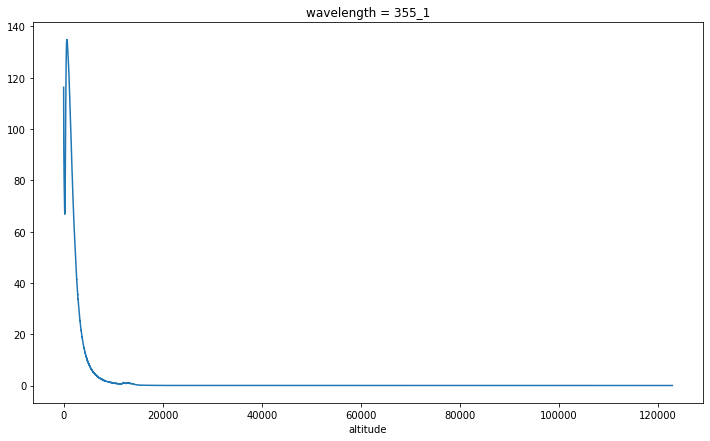

In [8]:
from lidarpy.data.clean import remove_background

lidar_clean = lidar_data.pipe(remove_background, [25_000, 80_000])

(lidar_clean
 .mean("time")
 .sel(wavelength="355_1")
 .plot(figsize=(12, 7)))

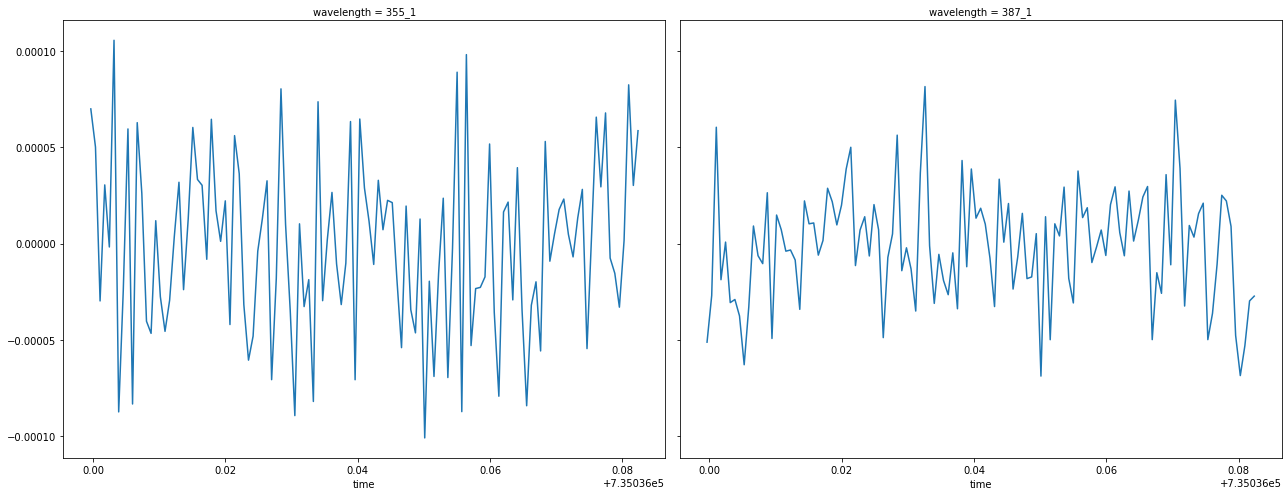

In [9]:
lidar_clean[:,[1,3],3000:].mean("altitude").plot(col="wavelength", figsize=(18, 7))

In [10]:
rcs_data = lidar_clean * lidar_clean.coords["altitude"] ** 2

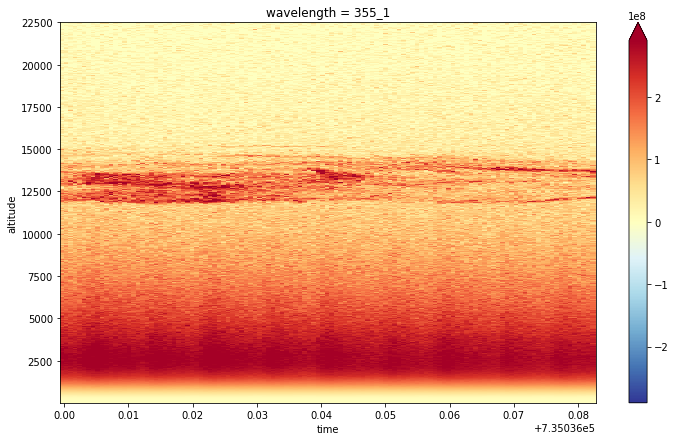

In [11]:
rcs_data[:, 1, 0:3000].plot(x="time", y="altitude", figsize=(12, 7), 
                            robust=True, cmap="RdYlBu_r")

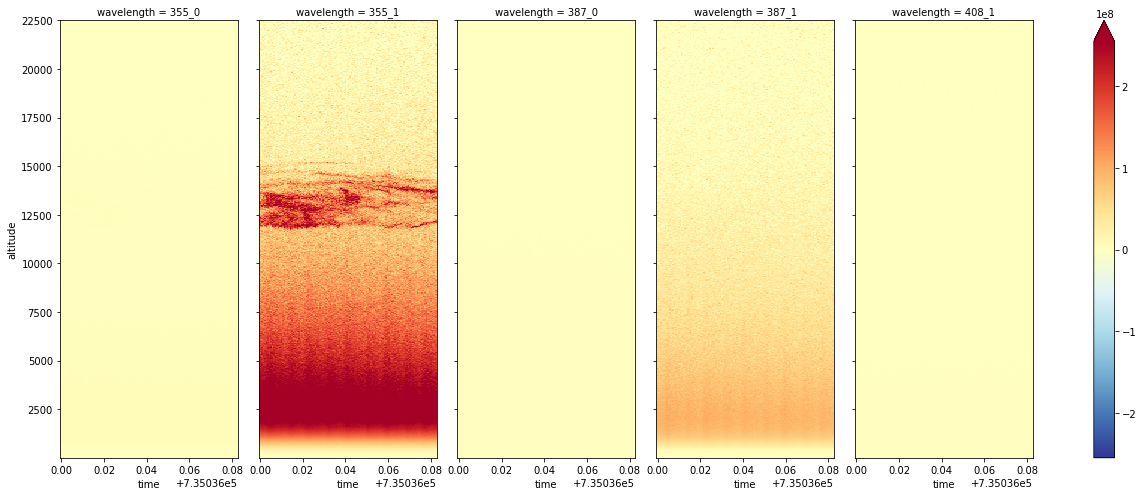

In [12]:
rcs_data[:, :, 0:3000].plot(x="time", col="wavelength", y="altitude", 
                            figsize=(18, 7), robust=True, cmap="RdYlBu_r")

In [14]:
rcs_data_mean = rcs_data.mean("time")

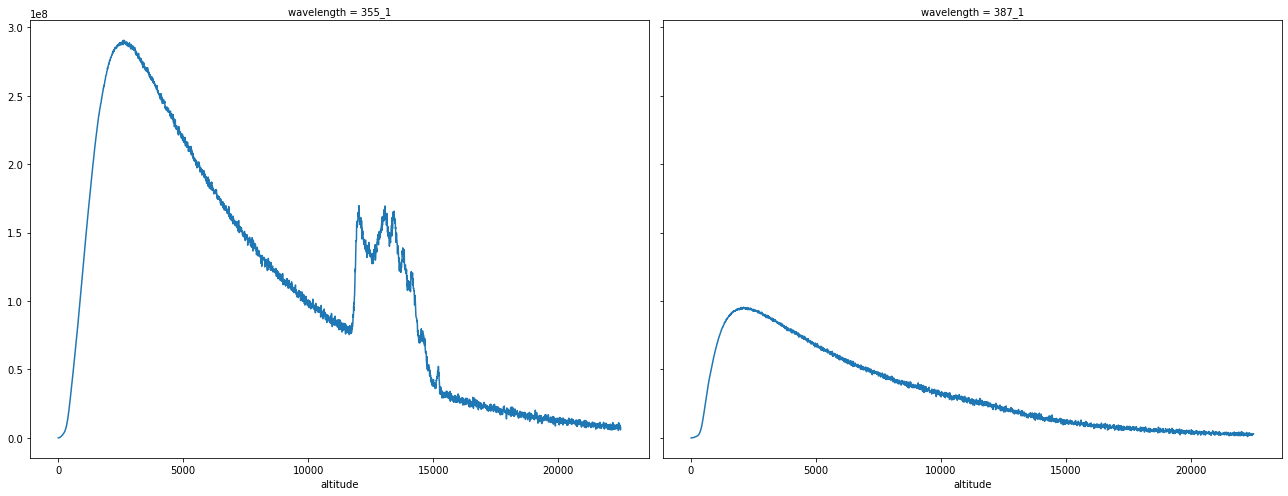

In [15]:
rcs_data_mean[[1,3], :3000].plot(col="wavelength", figsize=(18, 7))

# High level computation: groupby, resamble, rolling, coarsen, weighted

In [16]:
import numpy as np

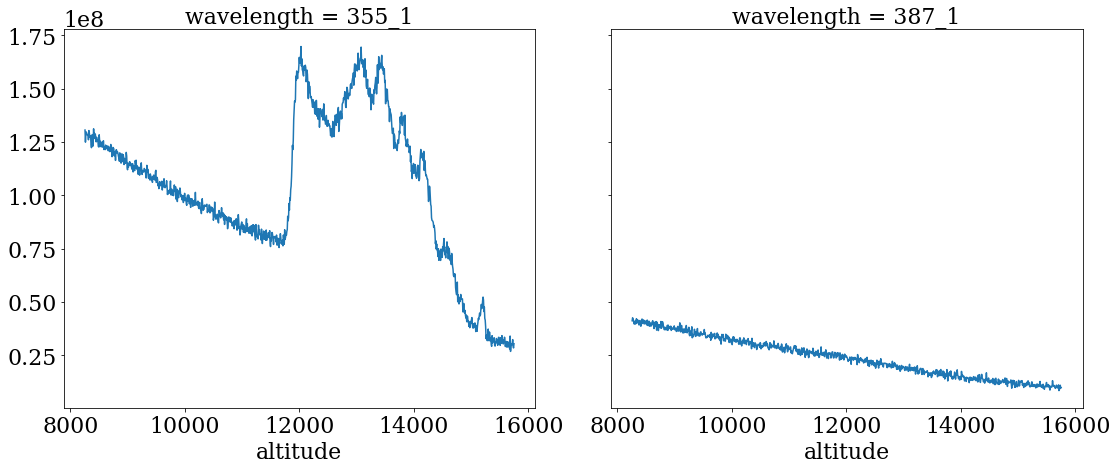

In [101]:
rcs_mean = rcs_data.mean("time")

rcs_mean[[1,3], 1100:2100].plot(col="wavelength", figsize=(16, 7))

In [102]:
rcs_mean[[1,3], 1100:2100].coords["altitude"]

<xarray.DataArray 'altitude' (altitude: 1000)>
array([ 8257.5,  8265. ,  8272.5, ..., 15735. , 15742.5, 15750. ])
Coordinates:
  * altitude  (altitude) float64 8.258e+03 8.265e+03 ... 1.574e+04 1.575e+04

# Inversão Raman

## Pré-processamento

In [120]:
rcs_mean

<xarray.DataArray (wavelength: 5, altitude: 16380)>
array([[-2.19884172e-01, -8.54301986e-01, -1.94000917e+00, ...,
         9.05347076e+06,  1.23517361e+07,  1.23687259e+07],
       [ 6.54071901e+03,  2.39120567e+04,  5.07152789e+04, ...,
        -1.00025286e+07, -1.00037501e+07, -1.00049717e+07],
       [-2.71246654e-01, -1.07584673e+00, -2.42629833e+00, ...,
         3.04940900e+07,  3.15679719e+07,  3.18990027e+07],
       [ 3.54620527e+03,  1.12813757e+04,  2.01606373e+04, ...,
        -4.95487359e+06, -4.95547868e+06, -7.28598502e+05],
       [ 1.33761850e+02,  3.22274290e+02,  5.09003707e+02, ...,
        -2.45669064e+06,  1.76997848e+06,  5.99767991e+06]])
Coordinates:
  * wavelength  (wavelength) <U5 '355_0' '355_1' '387_0' '387_1' '408_1'
  * altitude    (altitude) float64 7.5 15.0 22.5 ... 1.228e+05 1.228e+05

In [133]:
num = len(rcs_mean.coords["altitude"])

In [134]:
num // 5

3276

In [144]:
window = 5
group = [i for i in range(num // 5)]
group *= window
group.sort()

In [145]:
len(group)

16380

In [142]:
rcs_mean.shape

(5, 16380)

In [ ]:
def create_group(ds, n_bin):
  group = np.arange(num // 5)
  group *= n_bin
  group.sort()
  

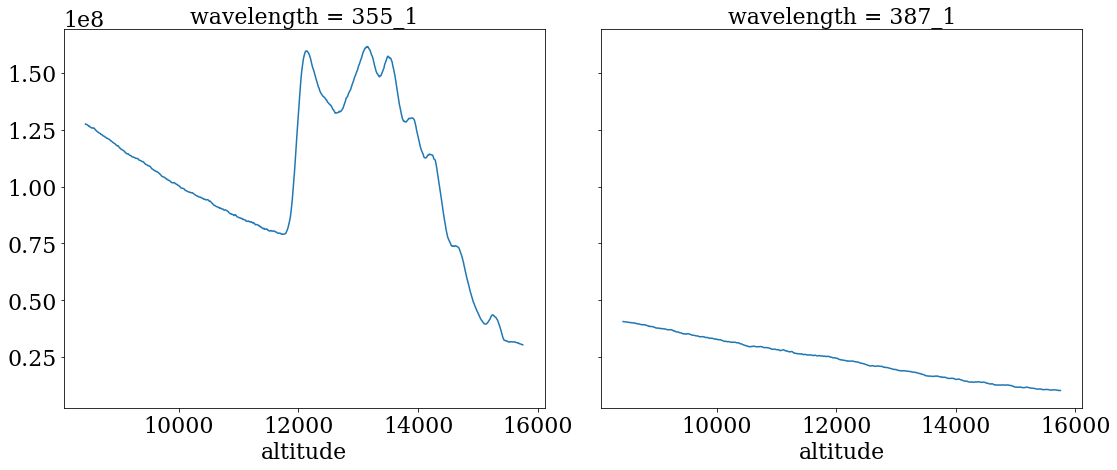

In [103]:
WINDOW = 25

rcs_mean[[1,3], 1100:2100].rolling(altitude=WINDOW).mean().plot(col="wavelength", figsize=(16, 7))

In [104]:
ds = (lidar_clean
      .mean("time")
      [[1,3], 1100:2100]
      .rolling(altitude=WINDOW)
      .mean()
      .dropna("altitude"))
ds

<xarray.DataArray (wavelength: 2, altitude: 976)>
array([[1.82999254, 1.82451354, 1.82137629, ..., 0.12456957, 0.12379646,
        0.12369562],
       [0.58243912, 0.58159878, 0.57925705, ..., 0.04180046, 0.04191251,
        0.04185649]])
Coordinates:
  * wavelength  (wavelength) <U5 '355_1' '387_1'
  * altitude    (altitude) float64 8.438e+03 8.445e+03 ... 1.574e+04 1.575e+04

## Parâmetros atmosféricos

In [105]:
z = ds.coords["altitude"].data
z.shape

(976,)

In [106]:
import pandas as pd
from scipy.interpolate import interp1d

df_sonde = pd.read_csv("lidarpy/tests/data/sonde_data.txt")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c3c1cec50>,
      dtype=object)

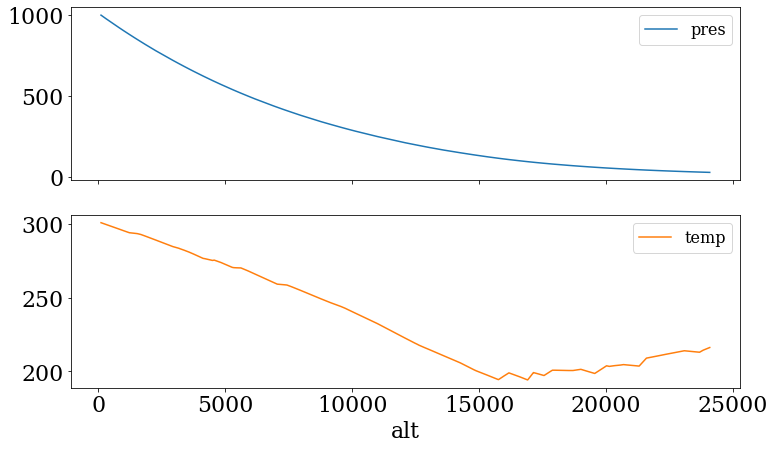

In [107]:
df_sonde.plot(x="alt", subplots=True, figsize=(12, 7))

In [108]:
f_temp = interp1d(df_sonde["alt"].to_numpy(), df_sonde["temp"].to_numpy())
f_pres = interp1d(df_sonde["alt"].to_numpy(), df_sonde["pres"].to_numpy())

In [109]:
temperature = f_temp(z)
pressure = f_pres(z)

temperature.shape, pressure.shape

((976,), (976,))

## Inversão

In [110]:
from lidarpy.inversion.raman import Raman

raman = Raman(ds,
              355,
              387,
              0,
              pressure,
              temperature,
              10_000)

In [111]:
raman.fit()

In [112]:
alpha, beta, lr = (raman.get_alpha()["elastic_aer"], 
                   raman.get_beta()["elastic_aer"], 
                   raman.get_lidar_ratio())

In [113]:
import matplotlib.pyplot as plt

def plot_3graph_std(z, 
                    alpha_avg, 
                    beta_avg, 
                    lidar_ratio_avg,
                    alpha_std=None,
                    beta_std=None,
                    lidar_ratio_std=None,
                    save_name=None):
  
    plt.rcParams.update({'font.family': 'serif', 'font.size': 22, 'font.weight': 'light'})
    plt.rc('legend',fontsize=16)

    alpha_label = r"Extinction ($\times 10^4$ m$^{-1}$)"
    beta_label = r"Backscatter ($\times 10^6$ m$^{-1}$sr$^{-1}$)"
    
    fmt = "-"
    alpha = 1 if alpha_std is None else 0.5
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    fig.set_figwidth(15)
    fig.set_figheight(9)

    ax1.plot(alpha_avg * 1e4, 
             z,
             fmt,
             alpha=alpha,
             color="black")
    
    if alpha_std is not None:
        ax1.fill_betweenx(z, 
                         (alpha_avg - alpha_std) * 1e4, 
                         (alpha_avg + alpha_std) * 1e4,
                         color='green', 
                         alpha=0.18)

    ax1.grid()
    ax1.grid(alpha=0.65)
    ax1.set_ylabel("Height (m)")
    ax1.set_xlabel(alpha_label)

    ax2.plot(beta_avg * 1e6, 
             z,
             fmt,
             alpha=alpha,
             color="black")

    if beta_std is not None:
        ax2.fill_betweenx(z, 
                         (beta_avg - beta_std) * 1e6, 
                         (beta_avg + beta_std) * 1e6,
                         color='green', 
                         alpha=0.18)

    ax2.grid()
    ax2.grid(alpha=0.65)
    ax2.set_xlabel(beta_label)

    ax3.plot(lidar_ratio_avg, 
             z,
             fmt,
             alpha=alpha,
             color="black", 
             label="Perfil computado")

    if lidar_ratio_std is not None:
        ax3.fill_betweenx(z, 
                         (lidar_ratio_avg - lidar_ratio_std), 
                         (lidar_ratio_avg + lidar_ratio_std),
                         color='green', 
                         alpha=0.18)

    ax3.grid()
    ax3.grid(alpha=0.65)
    ax3.set_xlabel(r"Lidar Ratio (sr)")
    ax3.legend()
    
    if save_name is not None:
        plt.savefig(f"figs/{save_name}")        
    
    plt.show()

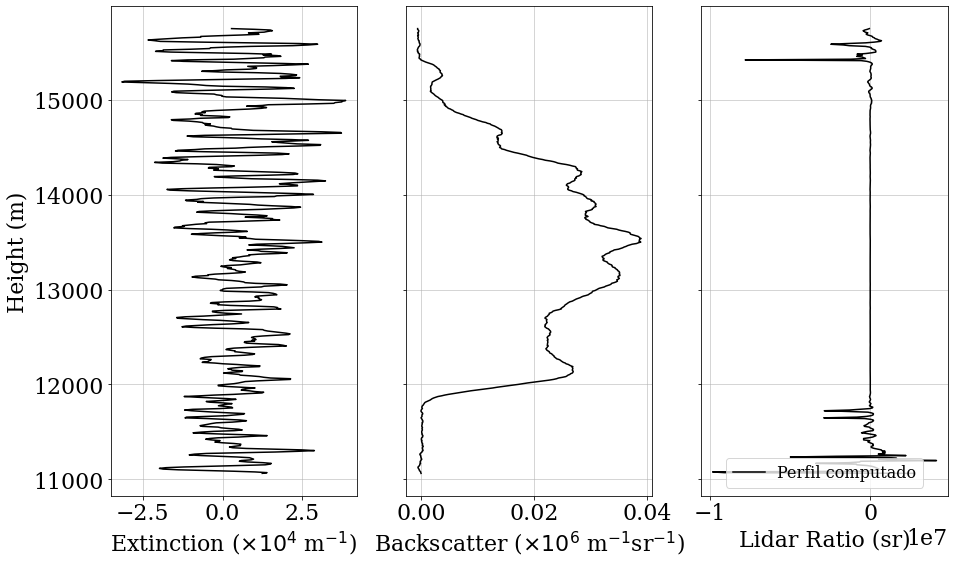

In [114]:
ind_min = 350
plot_3graph_std(z[ind_min:], alpha[ind_min:], beta[ind_min:], lr[ind_min:])

In [115]:
lr[ind_min:].mean()

-60934.43145315218